Notebook 3 - Prepare :
Après avoir exploré et nettoyé le dataset, nous allons effectuer des étapes de préparation par transformation des features en vue d'obtenir des performances optimales. 
Nous pouvons aussi appliquer la restriction des relevés aux bâtiments "non destinés à l'habitation", ainsi que ceux pour lesquels un relevé existe en 2015 mais pas en 2016 et inversement.

In [1]:
%load_ext pycodestyle_magic
%flake8_on

- importer les packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
# %matplotlib inline
# Pour afficher tout le contenu d'une valeur
pd.set_option('display.max_colwidth', -1)
# Pour afficher toutes les colonnes
pd.options.display.max_columns = 100

In [3]:
# récupérer les données
raw = pd.read_csv('dat3.csv')
buldings_in15not16 = pd.read_csv('in15not16.csv')
buldings_in16not15 = pd.read_csv('in16not15.csv')

In [4]:
# contrôler la taille des données
print(raw.shape)
print(buldings_in15not16.shape)
print(buldings_in16not15.shape)

(6337, 42)
(56, 2)
(92, 2)


In [5]:
# créer un jeu de données validation
valid1 = raw[raw['OSEBuildingID'].isin(buldings_in16not15['OSEBuildingID'])]
valid2 = raw[raw['OSEBuildingID'].isin(buldings_in15not16['OSEBuildingID'])] 

In [6]:
# contrôler la taille des données de validation
print(valid1.shape)
print(valid2.shape)
valid = pd.concat([valid1, valid2], sort=False).reset_index(drop=True)
print('Nb de buildings après concaténation : ' + str(valid.shape[0]))

(79, 42)
(39, 42)
Nb de buildings après concaténation : 118


## Catégorisation des features (avant traitement)

In [7]:
# lister les features disponibles
print(raw.columns.size)
raw.columns

42


Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Latitude', 'Longitude',
       'Select_Default', 'Select_Outlier', 'N_D_hasNaturalGas', 'N_D_hasSteam',
       'N_D_BuildingType', 'N_PrimaryPropertyType', 'N_D_NbPropUseRange',
       'N_AddUseType', 'N_PercentGFAParking', 'N_PercentGFABuilding',
       'N_TotUseGFA', 'LargestProp', 'SecLargestProp', 'ThirdLargestProp',
       'OtherPropertyUseTypeGFA', 'N_BuildingAge', 'N_D_NbofBuildingsRange',
       'N_D_NbofFloorsRange'],
      dtype='

In [8]:
# les features d'identification / tri des données : 4
Select_features = ['OSEBuildingID',
                   'DataYear',
                   'Select_Default',
                   'Select_Outlier']

In [9]:
# les features de proportion de surfaces - non utilisés : 4
Un_Surf_features = ['LargestProp',
                    'SecLargestProp',
                    'ThirdLargestProp',
                    'OtherPropertyUseTypeGFA']

In [10]:
# les features bruts exploitables pour une régression : 11
Raw_features = ['YearBuilt',
                'NumberofBuildings',
                'NumberofFloors',
                'PropertyGFATotal',
                'PropertyGFAParking',
                'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA',
                'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA',
                'Latitude',
                'Longitude']
len(Raw_features)

11

In [11]:
# les features bruts inexploitables pour une regression : 3
Un_Raw_features = ['LargestPropertyUseType',
                   'SecondLargestPropertyUseType',
                   'ThirdLargestPropertyUseType']

In [12]:
# les features dérivés à traiter retenu : 1, non retenu : 4
NTreat_features = ['N_BuildingAge']
Un_NTreat_features = ['N_PercentGFAParking',
                      'N_PercentGFABuilding',
                      'N_TotUseGFA',
                      'N_AddUseType']

In [13]:
# features dérivés pseudo numériques déjà viables : 6
N_D_features = ['N_D_hasNaturalGas',
                'N_D_hasSteam',
                'N_D_NbPropUseRange',
                'N_D_NbofBuildingsRange',
                'N_D_NbofFloorsRange',
                'N_D_BuildingType']

In [14]:
# features catégoriels retenus pour One hot encoding : 4
OH_Features = ['BuildingType',
               'CouncilDistrictCode',
               'Neighborhood',
               'N_PrimaryPropertyType']

In [15]:
# features de résultats : 4
Results = ['SiteEUI(kBtu/sf)',
           'SiteEnergyUse(kBtu)',
           'TotalGHGEmissions',
           'GHGEmissionsIntensity']

In [16]:
# contrôler l'absence de de données cibles négatives ou nulles
for i in Results:
    print('valeurs <= 0 de ' + str(i) + ' : ' + str(raw[raw[i] <= 0].shape))

valeurs <= 0 de SiteEUI(kBtu/sf) : (0, 42)
valeurs <= 0 de SiteEnergyUse(kBtu) : (0, 42)
valeurs <= 0 de TotalGHGEmissions : (0, 42)
valeurs <= 0 de GHGEmissionsIntensity : (0, 42)


In [17]:
# indiquer le nombre de Buildings sans ES Score
print('nb de valeurs inconues pour ESS : ' + str(raw['ENERGYSTARScore'].isna().sum()))

nb de valeurs inconues pour ESS : 1524


# Préparation

In [18]:
# copier les données
prep = raw.copy()

In [19]:
# fonction de one-hot encoding pour les données catégorielles


def onehot(data, feature):
    # transforme en binaire les catégories
    temp_df = pd.get_dummies(data[feature])
    # préfixe le nouveau feature
    temp_df = temp_df.add_prefix('N_OH_' + feature + '_')
    # ajoute le nouveau feature
    data = pd.concat([data, temp_df], axis=1)
    # retire le feature dans sa version d'origine
    data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data



In [20]:
# fonction de one-hot encoding spéciale :
# ranger la proportion de surface de chaque UseType selon une surface de référence
# paramètres : {data, feature, featureGFA, pref, ref}
# pref=valeur du préfixe L_ S_ ou T_
# ref=feature de surface pris pour référence
# 3 candidats pour la surface de référence :
# - 'PropertyGFABuilding(s)' (used to compute EUI)
# - 'PropertyGFATotal' (Parking + Building(s))
# - 'N_TotUseGFA' (somme des surfaces des 3 UseTypes)


def onehotspecial(data, feature, featureGFA, pref, ref):
    # transforme en binaire les catégories du feature
    temp_df = pd.get_dummies(data[feature])
    # préfixe le nouveau feature
    temp_df = temp_df.add_prefix(pref)
    # ajoute le nouveau feature
    data = pd.concat([data, temp_df], axis=1)
    # impute le pourcentage de surface du UseType
    for i in data.columns[data.columns.str.contains(pref)]:
        data[i] = data[i] * data[featureGFA]/data[ref]
    # retourne le nouveau dataframe
    return data



2:80: E501 line too long (82 > 79 characters)


In [21]:
# appliquer ce one-hot encoding spécial pour le 1er, 2ème et 3ème usage
prep = onehotspecial(prep,
                     'LargestPropertyUseType',
                     'LargestPropertyUseTypeGFA',
                     'L_',
                     'PropertyGFABuilding(s)')
prep = onehotspecial(prep,
                     'SecondLargestPropertyUseType',
                     'SecondLargestPropertyUseTypeGFA',
                     'S_',
                     'PropertyGFABuilding(s)')
prep = onehotspecial(prep,
                     'ThirdLargestPropertyUseType',
                     'ThirdLargestPropertyUseTypeGFA',
                     'T_',
                     'PropertyGFABuilding(s)')

In [22]:
# contrôler le nombre de features
prep.shape

(6337, 196)

In [23]:
# lister les UseType définis pour le 1er, 2ème et 3ème usage
largest = prep['LargestPropertyUseType'].unique()
second = prep['SecondLargestPropertyUseType'].unique()
third = prep['ThirdLargestPropertyUseType'].unique()

# consolider la liste des UseType
UseTypeList = list(largest)
UseTypeList.extend(x for x in second if x not in UseTypeList)
UseTypeList.extend(x for x in third if x not in UseTypeList)

# compter le nb d'UseType
len(UseTypeList)

66

In [24]:
# fusionner les UseType quelque soit l'ordre d'usage
for i in UseTypeList:
    j = str('_')+i
    UseTypeCols = [col for col in prep.columns if j in col]
    prep[i] = prep[UseTypeCols].sum(axis=1)

In [25]:
# contrôler le nb de features
prep.shape

(6337, 262)

In [26]:
# retirer les colonnes inutiles
DropCols = prep.columns[
    prep.columns.str.contains('L_')
    | prep.columns.str.contains('S_')
    | prep.columns.str.contains('T_')
]
prep.drop(DropCols, axis=1, inplace=True)
prep.shape

(6337, 108)

In [27]:
# appliquer l'encoding des variables catégorielles retenues
for i in OH_Features:
    print(i)
    prep = onehot(prep, i)
    print(prep.shape)

BuildingType
(6337, 115)
CouncilDistrictCode
(6337, 121)
Neighborhood
(6337, 133)
N_PrimaryPropertyType
(6337, 150)


In [28]:
# fonction de transformation des features numériques


def rankgauss(data, feature):
    # crée une instance de quatiletransformer
    transformer = QuantileTransformer(n_quantiles=100,
                                      random_state=1111,
                                      output_distribution='normal')
    # adpate au feature
    transformer.fit(data[[feature]])
    # préfixe le nouveau feature
    newfeat = str('N_RG_' + feature)
    # ajoute le nouveau feature transformé
    data[newfeat] = transformer.transform(data[[feature]])
    # nb on ne retire pas le feature dans sa version d'origine
    # retourne le nouveau dataframe
    return data



In [29]:
# appliquer le rankgauss aux features bruts
for i in Raw_features:
    print(i)
    prep = rankgauss(prep, i)
    print(prep.shape)

YearBuilt
(6337, 151)
NumberofBuildings
(6337, 152)
NumberofFloors
(6337, 153)
PropertyGFATotal
(6337, 154)
PropertyGFAParking
(6337, 155)
PropertyGFABuilding(s)
(6337, 156)
LargestPropertyUseTypeGFA
(6337, 157)
SecondLargestPropertyUseTypeGFA
(6337, 158)
ThirdLargestPropertyUseTypeGFA
(6337, 159)
Latitude
(6337, 160)
Longitude
(6337, 161)


In [30]:
# appliquer le rankgauss aux features dérivés retenus
for i in NTreat_features:
    print(i)
    prep = rankgauss(prep, i)
    print(prep.shape)

N_BuildingAge
(6337, 162)


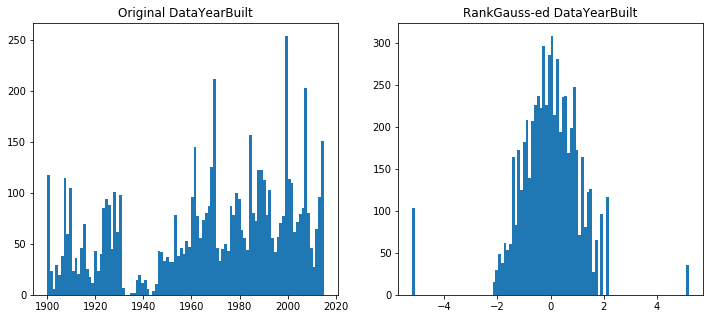

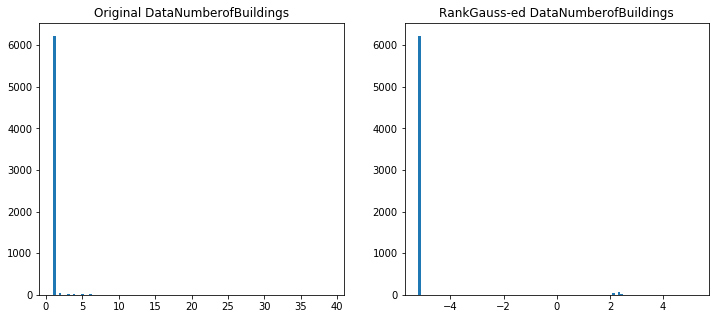

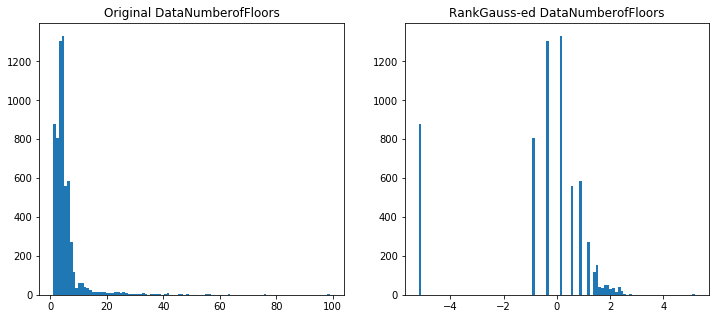

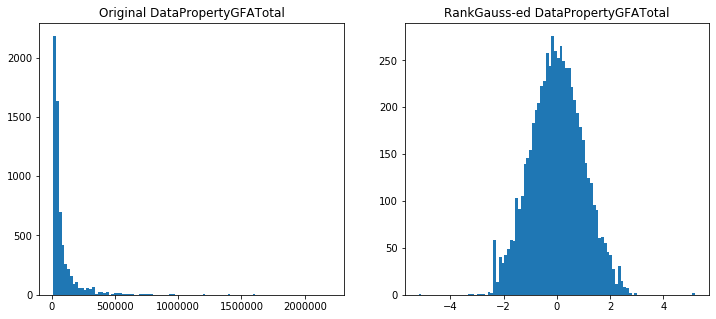

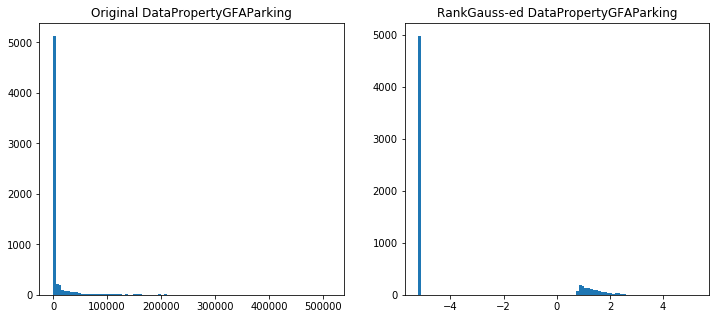

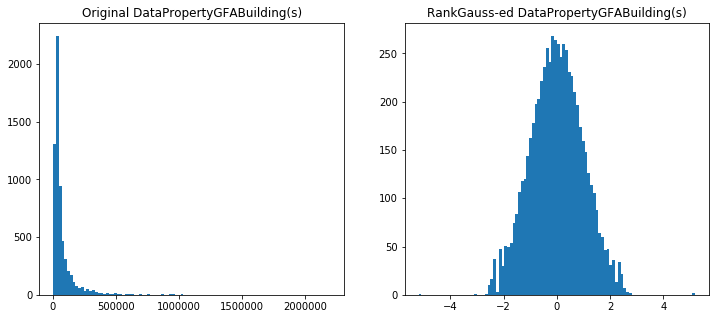

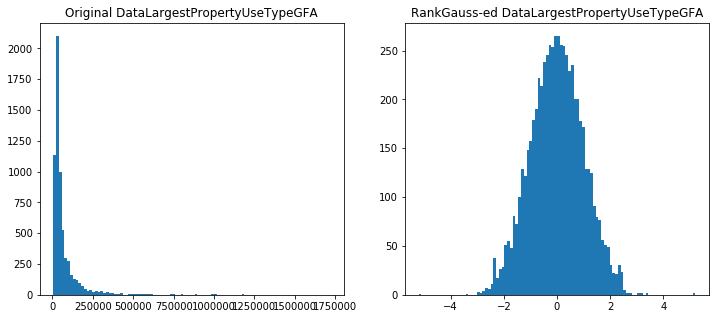

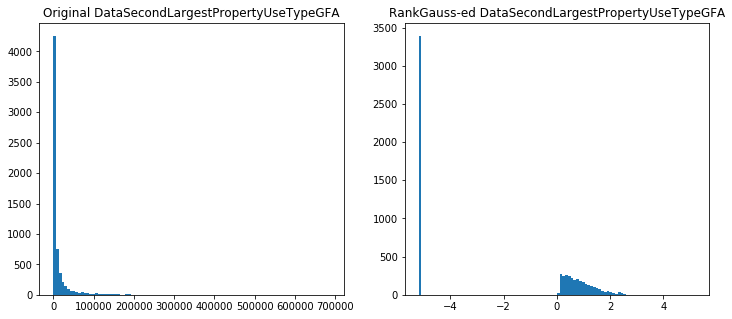

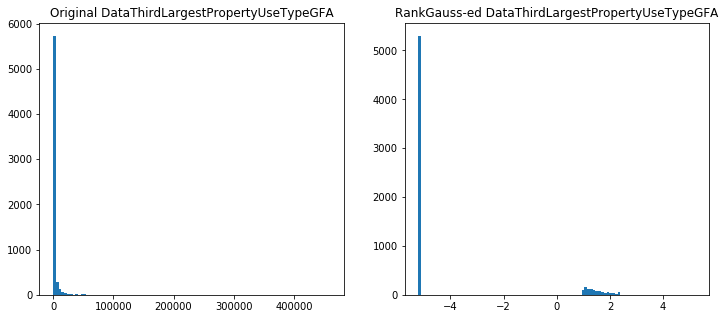

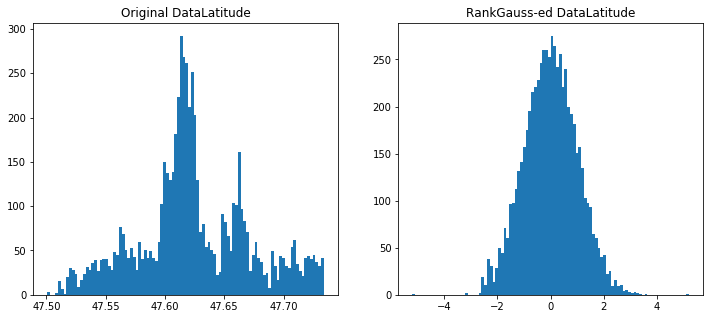

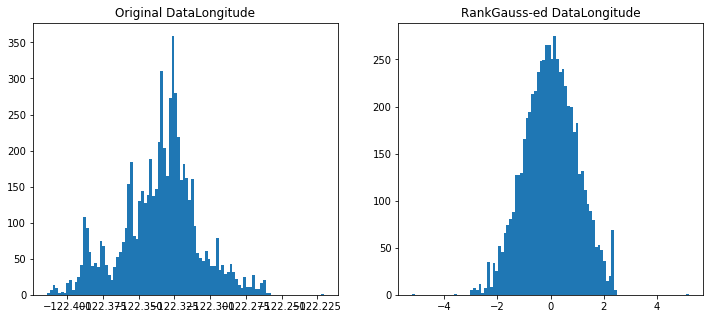

In [31]:
# observer le résultat du traitement rankgauss:
for i in Raw_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.hist(prep[i], bins=100)
    ax1.title.set_text(str('Original Data' + i))
    ax2.hist(prep[str('N_RG_' + i)], bins=100)
    ax2.title.set_text(str('RankGauss-ed Data' + i))
    plt.show()

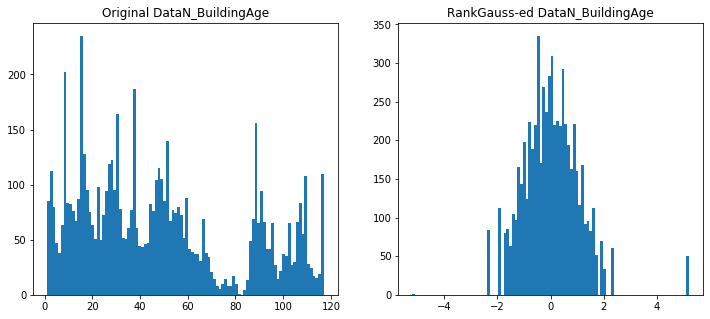

In [32]:
# observer le résultat du traitement :
for i in NTreat_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.hist(prep[i], bins=100)
    ax1.title.set_text(str('Original Data' + i))
    ax2.hist(prep[str('N_RG_' + i)], bins=100)
    ax2.title.set_text(str('RankGauss-ed Data' + i))
    plt.show()

## Catégorisation des features (après traitement)

- Catégorisation de tous les features ajoutés par les différents traitements.

In [33]:
# lister les features disponibles
print(prep.columns.size)
prep.columns

162


Index(['OSEBuildingID', 'DataYear', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA',
       ...
       'N_RG_NumberofFloors', 'N_RG_PropertyGFATotal',
       'N_RG_PropertyGFAParking', 'N_RG_PropertyGFABuilding(s)',
       'N_RG_LargestPropertyUseTypeGFA',
       'N_RG_SecondLargestPropertyUseTypeGFA',
       'N_RG_ThirdLargestPropertyUseTypeGFA', 'N_RG_Latitude',
       'N_RG_Longitude', 'N_RG_N_BuildingAge'],
      dtype='object', length=162)

- 124 features ont été ajoutés (en comptant les 4 features unitiaux BuildingType, CouncilDistrictCode, Neighborhood et N_PrimaryPropertyType supprimés après One Hot encoding)

In [34]:
# compter et lister les features catégories one hot encoding
Features_OH = prep.columns[prep.columns.str.contains('N_OH_')]
print(Features_OH.size)
Features_OH

46


Index(['N_OH_BuildingType_Campus', 'N_OH_BuildingType_Multifamily HR (10+)',
       'N_OH_BuildingType_Multifamily LR (1-4)',
       'N_OH_BuildingType_Multifamily MR (5-9)',
       'N_OH_BuildingType_NonResidential',
       'N_OH_BuildingType_Nonresidential COS',
       'N_OH_BuildingType_Nonresidential WA',
       'N_OH_BuildingType_SPS-District K-12', 'N_OH_CouncilDistrictCode_1',
       'N_OH_CouncilDistrictCode_2', 'N_OH_CouncilDistrictCode_3',
       'N_OH_CouncilDistrictCode_4', 'N_OH_CouncilDistrictCode_5',
       'N_OH_CouncilDistrictCode_6', 'N_OH_CouncilDistrictCode_7',
       'N_OH_Neighborhood_BALLARD', 'N_OH_Neighborhood_CENTRAL',
       'N_OH_Neighborhood_DELRIDGE', 'N_OH_Neighborhood_DOWNTOWN',
       'N_OH_Neighborhood_EAST', 'N_OH_Neighborhood_GREATER DUWAMISH',
       'N_OH_Neighborhood_LAKE UNION',
       'N_OH_Neighborhood_MAGNOLIA / QUEEN ANNE', 'N_OH_Neighborhood_NORTH',
       'N_OH_Neighborhood_NORTHEAST', 'N_OH_Neighborhood_NORTHWEST',
       'N_OH_Neighborhoo

- 46 features suite au One Hot Encoding des catégories

In [35]:
# décompter le nb de features traités pour OH et RG
Features_RG = prep.columns[prep.columns.str.contains('N_RG_')]
print(Features_RG.size)
Features_RG

12


Index(['N_RG_YearBuilt', 'N_RG_NumberofBuildings', 'N_RG_NumberofFloors',
       'N_RG_PropertyGFATotal', 'N_RG_PropertyGFAParking',
       'N_RG_PropertyGFABuilding(s)', 'N_RG_LargestPropertyUseTypeGFA',
       'N_RG_SecondLargestPropertyUseTypeGFA',
       'N_RG_ThirdLargestPropertyUseTypeGFA', 'N_RG_Latitude',
       'N_RG_Longitude', 'N_RG_N_BuildingAge'],
      dtype='object')

- 12 features suite au traitement numérique

In [36]:
# décompter le nb de features UseType
Features_UseType = prep.columns.intersection(UseTypeList)
print(Features_UseType.size)
Features_UseType

66


Index(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services', 'Other - Lodging/Residential',
       'Residence Hall/Dormitory', 'Other/Specialty Hospital',
       'Financial Office', 'Non-Refrigerated Warehouse', 'Distribution Center',
       'Parking', 'Worship Facility', 'Laboratory',
       'Supermarket/Grocery Store', 'Convention Center',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Services', 'Strip Mall',
       'Wholesale Club/Supercenter', 'Refrigerated Warehouse',
       'Other - Recreation', 'Lifestyle Center', 'Other - Public Services',
       'Data Center', 'Other - Mall', 'Ma

In [37]:
# exporter des données préparées :
prep.to_csv('prep.csv', index=False)

## validité des données pour une regression

In [38]:
# fonction identifiant les meilleures corrélations entre un feature et la cible
# paramètres : {data, features, target, sel_method, corrlevel}
# sel_method='pearson' ou "kendall' selon la nature du feature
# corrlevel=seuil de corrélation minimale


def features_corr(data, features, target, sel_method, corrlevel):
    for i in features:
        if abs(data[i].corr(np.log(data[target]), method=sel_method)) > corrlevel:
            print(str(i) + ' - ' + str(target) + ' : ' + str(round(data[i].corr(np.log(data[target])), 2)))


9:80: E501 line too long (82 > 79 characters)
10:80: E501 line too long (107 > 79 characters)


In [39]:
# calculer les corrélations de pearson pour les features numériques bruts avec chaque cible
for j in Results:
    print('- ' + str(j) + ' correlations :')
    features_corr(prep, Raw_features, j, 'pearson', 0.5)

- SiteEUI(kBtu/sf) correlations :
- SiteEnergyUse(kBtu) correlations :
PropertyGFATotal - SiteEnergyUse(kBtu) : 0.65
PropertyGFABuilding(s) - SiteEnergyUse(kBtu) : 0.63
LargestPropertyUseTypeGFA - SiteEnergyUse(kBtu) : 0.63
- TotalGHGEmissions correlations :
PropertyGFATotal - TotalGHGEmissions : 0.5
PropertyGFABuilding(s) - TotalGHGEmissions : 0.5
LargestPropertyUseTypeGFA - TotalGHGEmissions : 0.5
- GHGEmissionsIntensity correlations :


1:80: E501 line too long (91 > 79 characters)


In [40]:
# calculer les corrélations de pearson pour les features numériques traités avec chaque cible
for j in Results:
    print('- ' + str(j) + ' correlations :')
    features_corr(prep, prep.columns[prep.columns.str.contains('N_RG_')], j, 'pearson', 0.5)

- SiteEUI(kBtu/sf) correlations :
- SiteEnergyUse(kBtu) correlations :
N_RG_PropertyGFATotal - SiteEnergyUse(kBtu) : 0.76
N_RG_PropertyGFABuilding(s) - SiteEnergyUse(kBtu) : 0.75
N_RG_LargestPropertyUseTypeGFA - SiteEnergyUse(kBtu) : 0.72
- TotalGHGEmissions correlations :
N_RG_PropertyGFATotal - TotalGHGEmissions : 0.59
N_RG_PropertyGFABuilding(s) - TotalGHGEmissions : 0.6
N_RG_LargestPropertyUseTypeGFA - TotalGHGEmissions : 0.57
- GHGEmissionsIntensity correlations :


1:80: E501 line too long (93 > 79 characters)


In [41]:
# comparaison de l'année de construction versus age de construction
for j in Results:
    print('- ' + str(j) + ' correlations :')
    features_corr(prep, ['N_RG_YearBuilt', 'N_RG_N_BuildingAge'], j, 'pearson', 0)

- SiteEUI(kBtu/sf) correlations :
N_RG_YearBuilt - SiteEUI(kBtu/sf) : -0.03
N_RG_N_BuildingAge - SiteEUI(kBtu/sf) : 0.02
- SiteEnergyUse(kBtu) correlations :
N_RG_YearBuilt - SiteEnergyUse(kBtu) : 0.15
N_RG_N_BuildingAge - SiteEnergyUse(kBtu) : -0.16
- TotalGHGEmissions correlations :
N_RG_YearBuilt - TotalGHGEmissions : 0.05
N_RG_N_BuildingAge - TotalGHGEmissions : -0.05
- GHGEmissionsIntensity correlations :
N_RG_YearBuilt - GHGEmissionsIntensity : -0.13
N_RG_N_BuildingAge - GHGEmissionsIntensity : 0.15


In [42]:
prep.columns[prep.columns.str.contains('N_RG_')]

Index(['N_RG_YearBuilt', 'N_RG_NumberofBuildings', 'N_RG_NumberofFloors',
       'N_RG_PropertyGFATotal', 'N_RG_PropertyGFAParking',
       'N_RG_PropertyGFABuilding(s)', 'N_RG_LargestPropertyUseTypeGFA',
       'N_RG_SecondLargestPropertyUseTypeGFA',
       'N_RG_ThirdLargestPropertyUseTypeGFA', 'N_RG_Latitude',
       'N_RG_Longitude', 'N_RG_N_BuildingAge'],
      dtype='object')

In [43]:
# calculer les corrélations de kendal pour les features "pseudo-numériques" traités avec chaque cible
for j in Results:
    print('- ' + str(j) + ' correlations :')
    features_corr(prep, N_D_features, j, 'kendall', 0.2)

- SiteEUI(kBtu/sf) correlations :
N_D_hasNaturalGas - SiteEUI(kBtu/sf) : 0.32
N_D_BuildingType - SiteEUI(kBtu/sf) : 0.31
- SiteEnergyUse(kBtu) correlations :
N_D_hasNaturalGas - SiteEnergyUse(kBtu) : 0.32
N_D_NbPropUseRange - SiteEnergyUse(kBtu) : 0.28
N_D_NbofFloorsRange - SiteEnergyUse(kBtu) : 0.41
N_D_BuildingType - SiteEnergyUse(kBtu) : 0.3
- TotalGHGEmissions correlations :
N_D_hasNaturalGas - TotalGHGEmissions : 0.63
N_D_hasSteam - TotalGHGEmissions : 0.28
N_D_BuildingType - TotalGHGEmissions : 0.3
- GHGEmissionsIntensity correlations :
N_D_hasNaturalGas - GHGEmissionsIntensity : 0.71
N_D_BuildingType - GHGEmissionsIntensity : 0.27


1:80: E501 line too long (101 > 79 characters)


In [44]:
# calculer les corrélations de pearson pour les features UseType traités avec chaque cible
for j in Results:
    print('- ' + str(j) + ' correlations :')
    features_corr(prep, UseTypeList, j, 'pearson', 0.2)

- SiteEUI(kBtu/sf) correlations :
Multifamily Housing - SiteEUI(kBtu/sf) : -0.32
Non-Refrigerated Warehouse - SiteEUI(kBtu/sf) : -0.21
Supermarket/Grocery Store - SiteEUI(kBtu/sf) : 0.27
- SiteEnergyUse(kBtu) correlations :
Multifamily Housing - SiteEnergyUse(kBtu) : -0.29
Office - SiteEnergyUse(kBtu) : 0.23
- TotalGHGEmissions correlations :
Multifamily Housing - TotalGHGEmissions : -0.29
- GHGEmissionsIntensity correlations :
Multifamily Housing - GHGEmissionsIntensity : -0.26


1:80: E501 line too long (90 > 79 characters)
